### import libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import math   # for mathematical operations
# import matplotlib.pyplot as plt    # for plotting the images
# %matplotlib inline
import pandas as pd
from tensorflow.keras.preprocessing import image   # for preprocessing the images
from skimage.transform import resize   # for resizing images
from glob import glob
from tqdm import tqdm
import random
import pathlib
import itertools
import collections
import tensorflow as tf
import imageio
from IPython import display
from urllib import request
# from tensorflow_docs.vis import embed
import keras

2023-08-19 18:07:38.595940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **Reading and spletting the dataset**

In [2]:
#readind the dataset
model_df = pd.read_csv('model_df.csv')

#spletting the dataset using train_test_split
def split_dataset(df, test_size=0.2, random_state=42):
    X = df.drop('label', axis=1)
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    train_df = X_train
    train_df['label'] = y_train
    test_df = X_test
    test_df['label'] = y_test
    return train_df, test_df

train_df, test_df = split_dataset(model_df)

In [3]:
#the dataset containes the id, title, path, and label of the video
train_df.head(3)

,Unnamed: 0.2,Unnamed: 0.1,Unnamed: 0,id,title,path,new_path,label
1012,1012,1012,1013.0,6967707383166536962,Trả lời @uyenthanh204 uiya tui che mắt rồi ko ...,/content/drive/My Drive/videos/,videos/videos/,1
1653,1653,1653,1685.0,8EZ941fazGQ,Jealous Kisses - Sweet Kiss #lgbt #lgbtq #blsh...,/content/drive/My Drive/youtubeShort/,youtubeShort/youtubeShort/,1
1785,1785,1785,1835.0,5FM0ARekfOU,PRANKING MY BI FRIEND 🏳️‍🌈 #shorts #pride,/content/drive/My Drive/youtubeShort/,youtubeShort/youtubeShort/,1


In [8]:
print("Number of the training videos:", len(train_df))
print("Number of the testing videos:", len(test_df))

Number of the training videos: 1804
Number of the testing videos: 451


## **Load video's frames**

In [3]:
def load_frames(path, desired_frames=20, resize=(224, 126)):
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    
    # If the video has fewer frames than desired, take all frames
    if total_frames <= desired_frames:
        interval = 1
    else:
        interval = total_frames // desired_frames

    frames = []
    frame_idx = 0  # current frame index
    
    try:
        while frame_idx < total_frames:
            cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)  # jump to the specified frame index
            ret, frame = cap.read()
            if not ret:
                break

            # Resize and append the frames to the frame array
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            frame_idx += interval  # move to the next frame based on the interval
    finally:
        cap.release()

    return np.array(frames).reshape(-1, 224, 126, 3)

In [4]:
def get_video_frames_and_labels(df):
    video_ids = df['id']
    labels = df['label'].tolist()
    video_filenames = [f'{id}.mp4' for id in video_ids]
    video_directory = df['new_path']
    video_paths = [os.path.join(vd, vf) for vd, vf in zip(video_directory, video_filenames)]
    
    all_frames = []

    # For each video.
    for idx, path in tqdm(enumerate(video_paths), total=len(video_paths), desc="Processing videos"):
        if os.path.isfile(path):
            # Gather all its frames.
            frames = load_frames(path)
            all_frames.append(frames)
            np.save('frames.npy', np.array(all_frames))
        else:
            print(idx, 'this file does not exist')
            labels.pop(idx)  # Remove the label corresponding to the missing video
    return all_frames, labels

In [8]:
def clean_frames(frames, labels):
    trimmed_frames = []
    remove_idx = []
    for idx in range(len(frames)):
        # If the list has more than 20 frames, truncate it
        if frames[idx].shape[0] > 20:
            trimmed_frames.append(frames[idx][:20])
        # If the list has less than 20 frames, pad with zeros
        elif frames[idx].shape[0] < 20:
            remove_idx.append(idx)
        else:
            trimmed_frames.append(frames[idx])
    
    trimmed_frames = np.array(trimmed_frames)
    cleaned_labels = np.delete(labels, remove_idx)
    return trimmed_frames, cleaned_labels, remove_idx

In [ ]:
train_frames, train_labels = get_video_frames_and_labels(train_df)
trimmed_train_frames, cleaned_train_labels = clean_frames(train_frames, train_labels)

np.save('trimmed_train_frames.npy', trimmed_train_frames)
np.save('cleaned_train_labels.npy', cleaned_train_labels)

print(f"Frame features in train set: {trimmed_train_frames.shape}")
print(f"Labels in train set: {cleaned_train_labels.shape}")

In [36]:
test_frames, test_labels = get_video_frames_and_labels(test_df)
trimmed_test_frames, cleaned_test_labels, remove_idx = clean_frames(test_frames, test_labels)

np.save('trimmed_test_frames.npy', trimmed_test_frames)
np.save('cleaned_test_labels.npy', cleaned_test_labels)

print(f"Frame features in train set: {trimmed_test_frames.shape}")
print(f"Labels in train set: {cleaned_test_labels.shape}")

Processing videos:   2%|▏         | 11/451 [00:20<14:55,  2.03s/it]/tmp/ipykernel_138658/3503164673.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save('frames.npy', np.array(all_frames))
Processing videos:  13%|█▎        | 60/451 [02:14<18:24,  2.83s/it][NULL @ 0x55cefb0f7ec0] Invalid NAL unit size (1058 > 869).
[NULL @ 0x55cefb0f7ec0] missing picture in access unit with size 873
[h264 @ 0x55cef7204880] Invalid NAL unit size (1058 > 869).
[h264 @ 0x55cef7204880] Error splitting the input into NAL units.
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cef91a9300] stream 0, offset 0x41e0bd: partial file
[mov,mp4,m4a,3gp,3g2,mj2 @ 0x55cef91a9300] stream 1, offset 0x41e408: partial file
[NULL @ 0x55cefb0f7ec0] Invalid NAL unit size (1058 > 869).
[NULL @ 0x55cefb0f7ec0] missing p

Frame features in train set: (450, 20, 224, 126, 3)
Labels in train set: (450,)


In [14]:
trimmed_train_frames = np.load('trimmed_train_frames.npy')
cleaned_train_labels = np.load('cleaned_train_labels.npy')
trimmed_test_frames = np.load('trimmed_test_frames.npy')
cleaned_test_labels = np.load('cleaned_test_labels.npy')

## **using CNN-RNN to extract images features**

### **training CNN for features extraction**

**definind the CNN model (Resnet50) with unfreezing the last 5 layers**

In [5]:
def CNN_MODEL_TRAINABLE():
    from tensorflow.keras.applications import ResNet50
    from tensorflow.keras.applications.resnet50 import preprocess_input
    from tensorflow.keras.layers import Dense, Dropout

    # Load the ResNet50 model with weights pre-trained on ImageNet
    base_model = ResNet50(
        weights="imagenet",
        include_top=False,
        pooling="max",
        input_shape=(224, 126, 3),
    )

    # Unfreeze the last few layers
    for layer in base_model.layers[-5:]:  # you can adjust the number based on your needs
        layer.trainable = True

    # Append the classification layers
    inputs = keras.Input((224, 126, 3))
    preprocessed = preprocess_input(inputs)
    base_features = base_model(preprocessed)
    x = Dense(256, activation='relu')(base_features)  # Add more dense layers if necessary
    x = Dropout(0.8)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    cnn_model = keras.Model(inputs, outputs)
    cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


    return cnn_model, base_model

# Initialize the model and compile
model, base_model = CNN_MODEL_TRAINABLE() 

# Your training loop will now look a bit different. Instead of predicting features,
# you will train the model using the video frames and their associated labels.

In [6]:
from tensorflow import keras

def train_cnn_model():
    # Set a filepath to save the best weights
    filepath = "best_weights_resnet_trained.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 save_best_only=True, verbose=1)
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True)
    
    epochs = 40
    batch_size = 64
    
    model, base_model = CNN_MODEL_TRAINABLE()
    
    # Train the model with the checkpoint callback
    history = model.fit(
        train_frames,  # Input data
        train_labels,                                 # Labels
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,                         # Validation data
        callbacks=[checkpoint]                        # Add checkpoint to callbacks
    )
    
    # Load the best weights into the model
    model.load_weights(filepath)
    model.save(filepath)
    _, accuracy = model.evaluate(test_frames, test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
    # If you want to return the actual weight values, you can use:
    # best_weights = model.get_weights()

    return history, model, base_model #, best_weights  # uncomment this if returning actual weights


In [4]:
#load train labels and videos' frames
train_labels = np.load('cleaned_train_labels.npy')
train_videos = videos = np.load('trimmed_train_frames.npy')
selected_frames_train = [video[video.shape[0] // 2] for video in train_videos]
train_frames = np.array(selected_frames_train) 

test_labels = np.load('cleaned_test_labels.npy')
test_videos = np.load('trimmed_test_frames.npy')
#select the center frame from all videos
selected_frames_test = [video[video.shape[0] // 2] for video in test_videos]
test_frames = np.array(selected_frames_test) 

In [38]:
test_frames.shape

(450, 224, 126, 3)

**train the cnn model then use it for features extraction**

In [7]:
history, cnn_model1, base_model1 = train_cnn_model()

Epoch 1/40
23/23 [==============================] - ETA: 0s - loss: 3.3469 - accuracy: 0.5487
Epoch 1: val_accuracy improved from -inf to 0.51389, saving model to best_weights_resnet_trained.h5
23/23 [==============================] - 255s 10s/step - loss: 3.3469 - accuracy: 0.5487 - val_loss: 1001064.4375 - val_accuracy: 0.5139
Epoch 2/40
23/23 [==============================] - ETA: 0s - loss: 1.9603 - accuracy: 0.6099
Epoch 2: val_accuracy did not improve from 0.51389
23/23 [==============================] - 227s 10s/step - loss: 1.9603 - accuracy: 0.6099 - val_loss: 26233.9258 - val_accuracy: 0.4944
Epoch 3/40
23/23 [==============================] - ETA: 0s - loss: 0.7240 - accuracy: 0.6502
Epoch 3: val_accuracy improved from 0.51389 to 0.53333, saving model to best_weights_resnet_trained.h5
23/23 [==============================] - 233s 10s/step - loss: 0.7240 - accuracy: 0.6502 - val_loss: 41.3358 - val_accuracy: 0.5333
Epoch 4/40
23/23 [==============================] - ETA: 0s 

In [9]:
train_videos = np.load('trimmed_train_frames.npy')
train_labels = np.load('cleaned_train_labels.npy')
flattened_train_frames = np.concatenate(train_videos, axis=0)  # This will have shape (total_num_frames, 224, 126, 3)
test_videos = np.load('trimmed_test_frames.npy')
test_labels = np.load('cleaned_test_labels.npy')
flattened_test_frames = np.concatenate(test_videos, axis=0)  # This will have shape (total_num_frames, 224, 126, 3)

In [8]:
cnn_feature_extractor = keras.Model(
    inputs=base_model1.inputs,
    outputs=base_model1.layers[-1].output
)

In [10]:
extracted_images_features = cnn_feature_extractor.predict(flattened_train_frames)
images_features_shape = extracted_images_features.shape
print(f"video features shape: {images_features_shape}")

1124/1124 [==============================] - 1369s 1s/step
video features shape: (35960, 2048)


In [11]:
# Compute the number of frames in each video and restore the original shape of the frames
num_frames_per_video = [video.shape[0] for video in train_videos]
reconstructed_train_features = np.split(extracted_images_features, np.cumsum(num_frames_per_video)[:-1])
reconstructed_train_features = np.array(reconstructed_train_features)
np.save('reconstructed_train_features.npy', reconstructed_train_features)
reconstructed_train_features.shape

(1798, 20, 2048)

In [59]:
num_frames_per_video = [20 for video in train_videos]
reconstructed_train_features = np.split(extracted_images_features, np.cumsum(num_frames_per_video)[:-1])
reconstructed_train_features = np.array(reconstructed_train_features)
reconstructed_train_features.shape

(1798, 20, 2048)

In [34]:
test_videos = np.load('trimmed_test_frames.npy')

In [35]:
test_videos.shape

(1798, 20, 224, 126, 3)

In [30]:
extracted_image_features = cnn_feature_extractor.predict(flattened_test_frames)
image_features_shape = extracted_image_features.shape
print(f"video features shape: {image_features_shape}")

# Compute the number of frames in each video and restore the original shape of the frames
num_frames_per_video = [video.shape[0] for video in test_videos]
reconstructed_test_features = np.split(extracted_image_features, np.cumsum(num_frames_per_video)[:-1])
reconstructed_test_features = np.array(reconstructed_test_features)
reconstructed_test_features.shape

  80/1124 [=>............................] - ETA: 16:37

KeyboardInterrupt: 

In [101]:
train_masks = np.load('train_masks.npy')
print(train_masks.shape)
train_masks = np.delete(train_masks, [282, 583, 848, 1263, 1494, 1787], axis=0)
print(train_masks.shape)

(1804, 20)
(1798, 20)


In [105]:
test_masks = np.load('test_masks.npy')
test_masks = np.delete(test_masks, [296], axis=0)
print(test_masks.shape)

(450, 20)


### **RNN features extraction**

In [108]:
from tensorflow import keras

def RNN_MODEL():
    MAX_SEQ_LENGTH = 20
    NUM_FEATURES = 2048

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")
    
    # Use LSTM layers
    x = keras.layers.LSTM(512, return_sequences=True)(frame_features_input,  mask=mask_input)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.LSTM(256, return_sequences=True)(x)
    x = keras.layers.LSTM(128)(x)

    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(256, activation="relu")(x)

    # Binary classification output
    output = keras.layers.Dense(1, activation="sigmoid")(x)
    
    rnn_model = keras.Model([frame_features_input,mask_input] , output)

    rnn_model.compile(
        loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"]
    )
    return rnn_model

In [112]:
from tensorflow import keras

def train_rnn_model():
    # Set a filepath to save the best weights
    filepath = "/tmp/best_weights_resnet_trained_rnn.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 save_best_only=True, verbose=1)
    
    epochs = 30
    batch_size = 64
    
    model = RNN_MODEL()
    
    # Train the model with the checkpoint callback
    history = model.fit(
        [reconstructed_train_features, train_masks],  # Input data
        train_labels,                                 # Labels
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,                         # Validation data
        callbacks=[checkpoint]                        # Add checkpoint to callbacks
    )
    
    # Load the best weights into the model
    model.load_weights(filepath)
    
    _, accuracy = model.evaluate([reconstructed_test_features, test_masks], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    
    # If you want to return the actual weight values, you can use:
    # best_weights = model.get_weights()

    return history, model  #, best_weights  # uncomment this if returning actual weights


In [114]:
cnn_history, rnn_model = train_rnn_model()

Epoch 1/30
23/23 [==============================] - ETA: 0s - loss: 0.6957 - accuracy: 0.4708
Epoch 1: val_accuracy improved from -inf to 0.53333, saving model to /tmp/best_weights_resnet_trained_rnn.h5
23/23 [==============================] - 27s 747ms/step - loss: 0.6957 - accuracy: 0.4708 - val_loss: 0.6904 - val_accuracy: 0.5333
Epoch 2/30
23/23 [==============================] - ETA: 0s - loss: 0.6856 - accuracy: 0.5960
Epoch 2: val_accuracy improved from 0.53333 to 0.55000, saving model to /tmp/best_weights_resnet_trained_rnn.h5
23/23 [==============================] - 21s 932ms/step - loss: 0.6856 - accuracy: 0.5960 - val_loss: 0.6844 - val_accuracy: 0.5500
Epoch 3/30
23/23 [==============================] - ETA: 0s - loss: 0.6797 - accuracy: 0.6189
Epoch 3: val_accuracy improved from 0.55000 to 0.56667, saving model to /tmp/best_weights_resnet_trained_rnn.h5
23/23 [==============================] - 16s 679ms/step - loss: 0.6797 - accuracy: 0.6189 - val_loss: 0.6795 - val_accura

In [117]:
import pickle

with open('training_history_trained_resnet.pkl', 'wb') as file:
    pickle.dump(cnn_history.history, file)

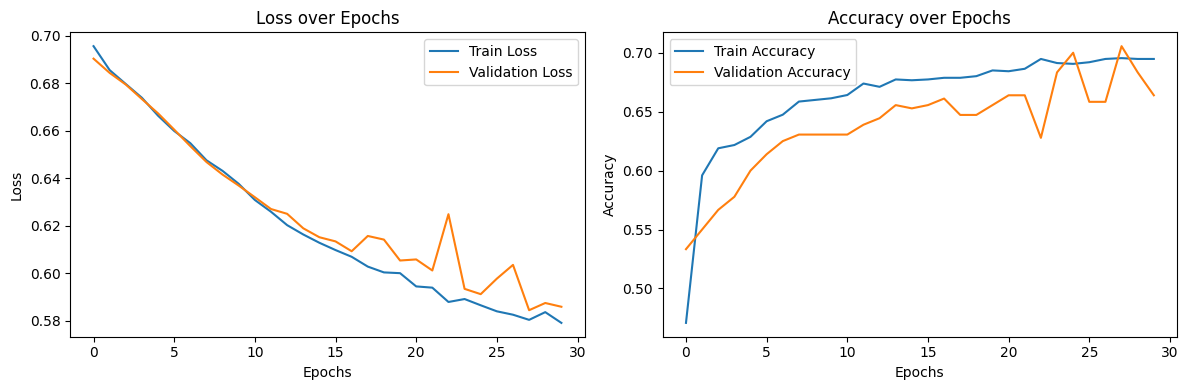

In [182]:
import matplotlib.pyplot as plt

# Plotting the loss for training and validation data
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the accuracy for training and validation data
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()


# Save the figure to a file
plt.savefig('training_plots_trained_resnet.png', dpi=300)
plt.show()

In [140]:
#extract the training features from the RNN model
rnn_feature_extractor = keras.Model(
    inputs=rnn_model.inputs,
    outputs=rnn_model.layers[-2].output
)

extracted_image_features = rnn_feature_extractor.predict([reconstructed_train_features, train_masks])
image_features_shape = extracted_image_features.shape
print(f"video features shape: {image_features_shape}")

57/57 [==============================] - 9s 88ms/step
video features shape: (1798, 256)


In [125]:
#extract the testing features from the RNN model
rnn_feature_extractor = keras.Model(
    inputs=rnn_model.inputs,
    outputs=rnn_model.layers[-2].output
)

test_extracted_image_features = rnn_feature_extractor.predict([reconstructed_test_features, test_masks])
test_image_features_shape = test_extracted_image_features.shape
print(f"video features shape: {test_image_features_shape}")

15/15 [==============================] - 11s 201ms/step
video features shape: (450, 256)


## **Getting text embeddings**

In [5]:
from transformers import TFBertModel, BertTokenizer

2023-08-15 04:57:00.060544: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


**get bert multingual model to extract text features**

In [6]:
#load bert model and its tokenizer
bert_model = TFBertModel.from_pretrained("bert-base-multilingual-cased")
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased")

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.01G [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

**get titles and replace empty fields with UNK**

In [10]:
train_titles = train_df['title']
train_titles = [title if isinstance(title, str) else "[UNK]" for title in train_titles]

test_titles = test_df['title']
test_titles = [title if isinstance(title, str) else "[UNK]" for title in test_titles]

**get the embeddings**

In [11]:
input_ids = tokenizer(train_titles, return_tensors="tf", padding=True, truncation=True, max_length=128)
outputs = bert_model(input_ids)
train_embeddings = outputs[1]

In [58]:
input_ids_test = tokenizer(test_titles, return_tensors="tf", padding=True, truncation=True, max_length=128)
outputs_test = bert_model(input_ids_test)
test_embeddings = outputs_test[1]

In [15]:
np.save('train_embeddings.npy', train_embeddings.numpy())
np.save('test_embeddings.npy', test_embeddings.numpy())

In [41]:
train_embeddings.numpy().shape

(1804, 768)

In [48]:
extracted_image_features.shape

(1804, 8)

In [145]:
train_embeddings = np.load('train_embeddings.npy')
test_embeddings = np.load('test_embeddings.npy')

In [146]:
test_embeddings = np.delete(test_embeddings, [260], axis=0)

In [147]:
test_embeddings.shape

(450, 768)

In [148]:
train_embeddings = np.delete(train_embeddings, [282, 583, 848, 1263, 1494, 1787], axis=0)
train_embeddings.shape

(1798, 768)

## **Fused network**

In [149]:
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras import backend as K

def F1_Score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall) / (precision + recall + K.epsilon())
    
    return f1_val

In [150]:
#create the fused model, this model combine the features of the frames and the embeddings of the titles
def FUSED_NN():
    # Assuming image_features is the output tensor from your image model
    image_input = tf.keras.Input(shape=(256, ), name="image_input")  # replace image_features_shape with the shape of your image features

    # BERT embeddings
    text_input = tf.keras.Input(shape=(768, ), name="text_input")  # BERT base models have an output dimension of 768

    fused = tf.keras.layers.Concatenate()([image_input, text_input])

    # Fully Connected Layers
    dense = tf.keras.layers.Dense(512, activation='relu')(fused)
    dense = tf.keras.layers.Dense(256, activation='relu')(dense)
    dense = tf.keras.layers.Dense(126, activation='relu')(dense)
    # Output layer for binary classification
    output = tf.keras.layers.Dense(1, activation='sigmoid')(dense)  # Single neuron with sigmoid activation

    # Construct the model
    fused_model = tf.keras.Model(inputs=[image_input, text_input], outputs=output)

    # Compile the model for binary classification
    fused_model.compile(optimizer='adam', 
                    loss='binary_crossentropy', 
                    metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), F1_Score])    
    return fused_model

In [153]:
from tensorflow import keras

def train_fused_model():
    # Set a filepath to save the best weights
    filepath = "/tmp/best_weights.h5"
    checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True,
                                                 monitor='val_accuracy', mode='max',
                                                 save_best_only=True, verbose=1)
    
    epochs = 50
    batch_size = 32
    
    image_features_train = extracted_image_features
    text_features_train = train_embeddings
    
    model = FUSED_NN()
    
    # Train the model with the checkpoint callback
    history = model.fit(
        [extracted_image_features, text_features_train],  # Input data
        train_labels,                                 # Labels
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,                         # Validation data
        callbacks=[checkpoint]                        # Add checkpoint to callbacks
    )
    
    # Load the best weights into the model
    model.load_weights(filepath)
    
    _, accuracy, precision, recall, f1_score = model.evaluate([test_extracted_image_features, test_embeddings], test_labels)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test precision: {round(precision * 100, 2)}%")
    print(f"Test recall: {round(recall * 100, 2)}%")
    print(f"Test f1_score: {round(f1_score * 100, 2)}%")
    
    # If you want to return the actual weight values, you can use:
    # best_weights = model.get_weights()

    return history, model  #, best_weights  # uncomment this if returning actual weights


In [154]:
fused_history, fused_model = train_fused_model()

Epoch 1/50
42/45 [===========================>..] - ETA: 0s - loss: 0.5292 - accuracy: 0.7351 - precision: 0.7391 - recall: 0.7782 - F1_Score: 0.7250     
Epoch 1: val_accuracy improved from -inf to 0.77222, saving model to /tmp/best_weights.h5
45/45 [==============================] - 2s 17ms/step - loss: 0.5263 - accuracy: 0.7392 - precision: 0.7469 - recall: 0.7731 - F1_Score: 0.7286 - val_loss: 0.4893 - val_accuracy: 0.7722 - val_precision: 0.7085 - val_recall: 0.9029 - val_F1_Score: 0.7818
Epoch 2/50
37/45 [=======================>......] - ETA: 0s - loss: 0.4273 - accuracy: 0.7990 - precision: 0.8250 - recall: 0.7882 - F1_Score: 0.7946
Epoch 2: val_accuracy improved from 0.77222 to 0.79167, saving model to /tmp/best_weights.h5
45/45 [==============================] - 0s 8ms/step - loss: 0.4232 - accuracy: 0.8074 - precision: 0.8393 - recall: 0.7901 - F1_Score: 0.8034 - val_loss: 0.4831 - val_accuracy: 0.7917 - val_precision: 0.7193 - val_recall: 0.9371 - val_F1_Score: 0.8024
Epoch

In [156]:
import pickle

with open('training_history_resnet_trained_fused.pkl', 'wb') as file:
    pickle.dump(fused_history.history, file)

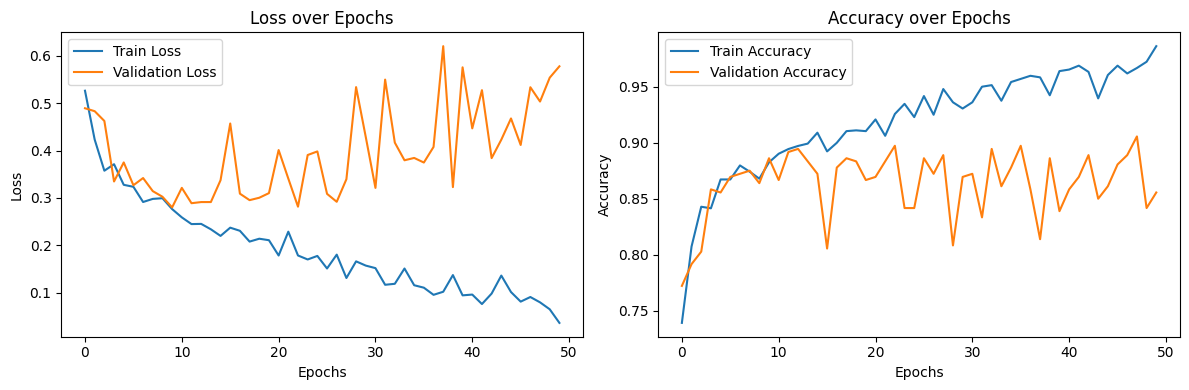

In [181]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(fused_history.history['loss'], label='Train Loss')
plt.plot(fused_history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plotting the accuracy for training and validation data
plt.subplot(1, 2, 2)
plt.plot(fused_history.history['accuracy'], label='Train Accuracy')
plt.plot(fused_history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.savefig('fused_plots_resnet_trained.png', dpi=300)

plt.tight_layout()
plt.show()